In [255]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import random

import torch

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
X = torch.rand(32, 10080, 2)

In [52]:
import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata
from wearables.scripts import train_v42 as weartrain
from wearables.scripts import eval_v42 as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

from wearables.scripts import data_augmentation as aug

In [50]:
# load data

model_fp = '/home/ngrav/project/wearables/model_zoo'

bst_trainer = os.path.join(model_fp, 'trainer_cnnv43l1l2_GA5.pkl')
bst_modelpkl = os.path.join(model_fp, '6143-cnnv43l1l2_GA5.pkl')


In [53]:
# # fix potential issue with net
net = wearmodels.CNN(2, 10080, 1, [(1, 32), (1, 64), (1, 128), (3, 256)])

# best CNN
_, md_model, trainer = weardtw.data_from_trainer(bst_trainer)

# fix issue with net
trainer.model = net

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer, split='train',
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# viz augmentations

Select random index

In [75]:
def printdata(X):
    print('X:\n', X, '\n\nShape:\n', X.shape)

In [228]:
batch = next(iter(trainer.data.train_dl))
X = batch['x']
printdata(X)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


X:
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[6.3648, 5.8289, 5.7621,  ..., 0.0000, 0.0000, 0.0000],
         [3.6604, 2.6997, 3.1728,  ..., 1.1787, 1.2879, 1.2879]],

        [[4.4659, 3.4657, 4.3944,  ..., 0.0000, 0.0000, 0.0000],
         [0.6614, 2.4259, 2.5055,  ..., 3.1570, 2.9832, 2.8109]],

        ...,

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [2.4891, 2.8904, 2.9806,  ..., 0.0000, 0.0000, 0.0000]]]) 

Shape:
 torch.Size([64, 2, 10080])


In [229]:
# select random index
idx = np.random.choice(np.arange(x.shape[0]), 1).item()
print('batch_idx: {}, unique_id: {}'.format(idx, batch['id'][idx]))

batch_idx: 56, unique_id: 1073_19


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


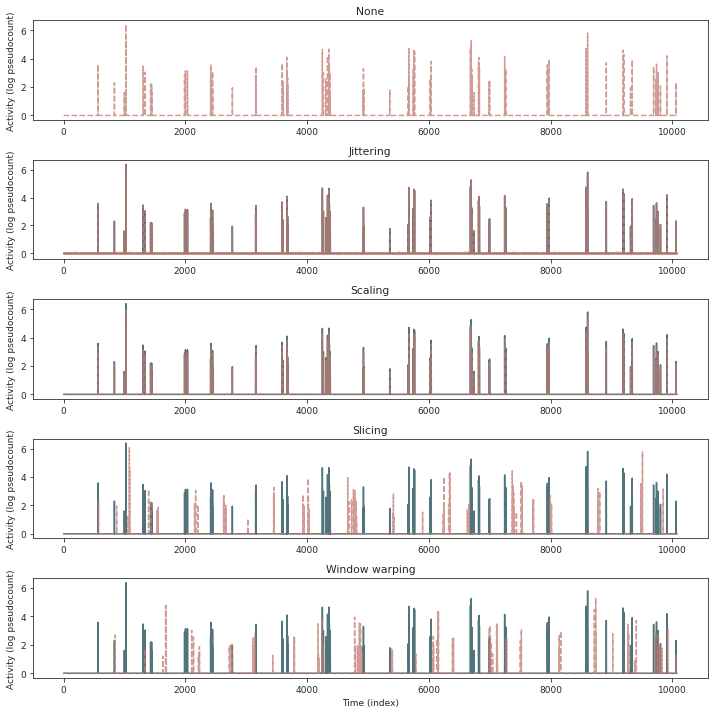

In [247]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
ax[0].plot(np.arange(X.shape[2]), X[idx, 0, :], label='raw data', color=sns.color_palette("cubehelix", 8)[4], linestyle='--', alpha=0.75)
ax[0].set_xlabel('')
ax[0].set_ylabel('Activity (log pseudocount)')
ax[0].set_title('None')

ax[1].plot(np.arange(X.shape[2]), X[idx, 0, :], label='raw data', color=sns.color_palette("cubehelix", 8)[1], alpha=0.75)
ax[1].plot(np.arange(X.shape[2]), aug.jitter(X[idx, :, :].unsqueeze(0))[0, 0, :], label='transform', color=sns.color_palette("cubehelix", 8)[4], linestyle='--', alpha=0.75)
ax[1].set_xlabel('')
ax[1].set_ylabel('Activity (log pseudocount)')
ax[1].set_title('Jittering')

ax[2].plot(np.arange(X.shape[2]), X[idx, 0, :], label='raw data', color=sns.color_palette("cubehelix", 8)[1], alpha=0.75)
ax[2].plot(np.arange(X.shape[2]), aug.scaling(X[idx, :, :].unsqueeze(0))[0, 0, :], label='transform', color=sns.color_palette("cubehelix", 8)[4], linestyle='--', alpha=0.75)
ax[2].set_xlabel('')
ax[2].set_ylabel('Activity (log pseudocount)')
ax[2].set_title('Scaling')

ax[3].plot(np.arange(X.shape[2]), X[idx, 0, :], label='raw data', color=sns.color_palette("cubehelix", 8)[1], alpha=0.75)
ax[3].plot(np.arange(X.shape[2]), aug.slicing(X[idx, :, :].unsqueeze(0))[0, 0, :], label='transform', color=sns.color_palette("cubehelix", 8)[4], linestyle='--', alpha=0.75)
ax[3].set_xlabel('')
ax[3].set_ylabel('Activity (log pseudocount)')
ax[3].set_title('Slicing')

ax[4].plot(np.arange(X.shape[2]), X[idx, 0, :], label='raw data', color=sns.color_palette("cubehelix", 8)[1], alpha=0.75)
ax[4].plot(np.arange(X.shape[2]), aug.window_warping(X[idx, :, :].unsqueeze(0))[0, 0, :], label='transform', color=sns.color_palette("cubehelix", 8)[4], linestyle='--', alpha=0.75)
ax[4].set_xlabel('Time (index)')
ax[4].set_ylabel('Activity (log pseudocount)')
ax[4].set_title('Window warping')

fig.tight_layout()

fig.savefig('/home/ngrav/project/wearables/results/data_aug_rand_id{}.pdf'.format(batch['id'][idx]), bbox_inches='tight', dpi=600, transparent=True)

# viz transforms

* 1 random VS all (random order of operations)
* different transform per minibatch VS per epoch

## impoementation in training

### per mb

### per epoch

## 1 random VS all

In [281]:
import importlib
importlib.reload(aug)

<module 'wearables.scripts.data_augmentation' from '/home/ngrav/project/wearables/scripts/data_augmentation.py'>

In [282]:
# test data augmenter 

Xprime, augsapplied = aug.augment_data(X[idx, :, :].unsqueeze(0), 
                                       mode = ['all'], verbose=True)


Transforms requested: ['all']
  applying all
  ... applied ['WW', 'N', 'J', 'Sl', 'Sc'] in 0-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


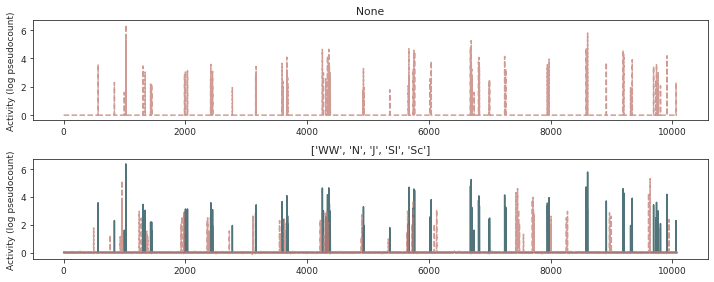

In [283]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4))
ax[0].plot(np.arange(X.shape[2]), X[idx, 0, :], label='raw data', color=sns.color_palette("cubehelix", 8)[4], linestyle='--', alpha=0.75)
ax[0].set_xlabel('')
ax[0].set_ylabel('Activity (log pseudocount)')
ax[0].set_title('None')

ax[1].plot(np.arange(X.shape[2]), X[idx, 0, :], label='raw data', color=sns.color_palette("cubehelix", 8)[1], alpha=0.75)
ax[1].plot(np.arange(X.shape[2]), Xprime[0, 0, :], label='transform', color=sns.color_palette("cubehelix", 8)[4], linestyle='--', alpha=0.75)
ax[1].set_xlabel('')
ax[1].set_ylabel('Activity (log pseudocount)')
ax[1].set_title('{}'.format(augsapplied))

fig.tight_layout()

fig.savefig('/home/ngrav/project/wearables/results/data_aug_all_randorder_id{}.pdf'.format(batch['id'][idx]), bbox_inches='tight', dpi=600, transparent=True)

In [284]:
X[idx, 0, :] == Xprime[0, 0, :]

tensor([False, False, False,  ..., False, False, False])

In [ ]:
transform_bank

['Sl', 'WW', 'Sc', 'J', 'N']